## Specification of start years for PPEs
Seeking start years that are ~25 years apart and sample multi-decadal variability of Southern Ocean ventilation
- calculate AABW overturning strength
- get pdf of AABW overturning strength
- sample evenly from this pdf

Also look at quantities such as ENSO to ensure even sampling.

**9.20.21** Realised that sampling strategy based on selecting one year from each of 10 bins actually gives a **uniform** distribution across sampled AABW strengths. This is of course not the same statistics as the control. So, I think I actually want to take from each bin a number of start years consistent with a discrete normal distribution. This would be, I think, (0,0,0,2,3,3,2,0,0,0).

In [132]:
import xarray as xr
import numpy as np
from xhistogram.xarray import histogram
import pandas as pd
import glob
from dask.diagnostics import ProgressBar

In [133]:
paths = '../data/raw/CTRL/pp/ocean_annual_rho2/ts/annual/5yr/ocean_annual_rho2.0[2-5]*.vmo.nc'
ds = xr.open_mfdataset(glob.glob(paths),use_cftime=True)

In [134]:
def cumsum_r(da,dim):
    '''Reverse cumulative sum'''
    cumsum = da.reindex({dim:list(reversed(da[dim]))}).cumsum(dim)
    return cumsum.reindex({dim:list(reversed(cumsum[dim]))})

def calc_psi(vmo,latitude,zdim='rho2_l'):
    '''Calculate overturning streamfunction'''
    return cumsum_r(vmo.sum('xh').sel(yq=latitude,method='nearest'),dim='rho2_l')

def calc_maxpsi(vmo,latitude,zdim='rho2_l',threshold=1036.7):
    '''Retrieve maximum of psi in z-dimension'''
    psi = calc_psi(vmo,latitude,zdim=zdim)
    return psi.where(psi[zdim]>threshold).max(zdim)

In [135]:
vmo = ds['vmo']
maxpsi = calc_maxpsi(vmo,-60)
maxpsi

<xarray.DataArray 'vmo' (time: 400)>
dask.array<nanmax-aggregate, shape=(400,), dtype=float32, chunksize=(5,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0201-07-02 12:00:00 ... 0600-07-02 12:00:00
    yq       float64 -60.02

In [136]:
nbins = 11
binmin=0.4e10
binmax=2.9e10
bins = np.linspace(binmin,binmax,nbins)
maxpsi_hist = histogram(maxpsi,bins=[bins],dim=['time'],density=True)
maxpsi_hist

<xarray.DataArray 'histogram_vmo' (vmo_bin: 10)>
dask.array<truediv, shape=(10,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
  * vmo_bin  (vmo_bin) float64 5.25e+09 7.75e+09 ... 2.525e+10 2.775e+10

[########################################] | 100% Completed | 46.1s


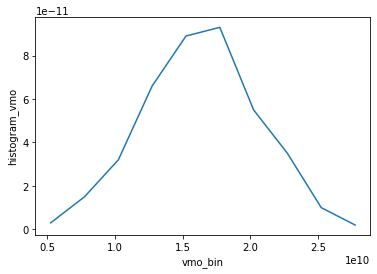

In [123]:
with ProgressBar():
    maxpsi_hist.plot()

In [138]:
with ProgressBar():
    maxpsi = maxpsi.load()

[########################################] | 100% Completed | 49.5s


In [180]:
df = pd.DataFrame({'maxpsi':maxpsi,'time':np.arange(len(maxpsi['time']))})
df

,maxpsi,time
0,6.666611e+09,0
1,1.302081e+10,1
2,1.482284e+10,2
3,1.358757e+10,3
4,1.666255e+10,4
...,...,...
395,1.613671e+10,395
396,2.247142e+10,396
397,1.265563e+10,397
398,2.252536e+10,398


In [232]:
def grab(x):
    return np.random.choice(x,1)[0]

def find_years(groups):
    times = groups['time'].apply(grab)
    years = np.sort(times.to_numpy())
    return years

def eval_spacing(years,minspacing=10):
    return np.all(np.greater(np.diff(years),spacing))

def get_years_with_spacing(groups,minspacing=10):
    allgreater=False
    ni=0
    while not allgreater:
        years = find_years(groups)
        allgreater = eval_spacing(years,minspacing=minspacing)
        ni+=1
    return years,ni

In [235]:
bins_pd = pd.cut(df['maxpsi'],bins)
groups = df.groupby(bins_pd)
%time years, ni = get_years_with_spacing(groups,minspacing=10)
print("years : "+str(years))
print("spacing : "+str(np.diff(years)))
print("niter : "+str(ni))

CPU times: user 17 s, sys: 76.8 ms, total: 17.1 s
Wall time: 17 s
years : [ 11  37  76 108 161 244 272 318 357 388]
spacing : [26 39 32 53 83 28 46 39 31]
niter : 10231


### 25-year spacings
years : [ 11  37  76 108 161 244 272 318 357 388]  
spacing : [26 39 32 53 83 28 46 39 31]

In [237]:
maxpsi_sample = maxpsi.isel({'time':years})
maxpsi_hist.plot()


<xarray.DataArray 'histogram_vmo' (vmo_bin: 10)>
array([4.e-11, 4.e-11, 4.e-11, 4.e-11, 4.e-11, 4.e-11, 4.e-11, 4.e-11,
       4.e-11, 4.e-11])
Coordinates:
  * vmo_bin  (vmo_bin) float64 5.25e+09 7.75e+09 ... 2.525e+10 2.775e+10